In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 20.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'

mpl.rcParams['legend.fontsize'] = 'medium'

mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titleweight'] = 'heavy'

# print(mpl.rcParams.keys())

   

In [3]:
def overlap( X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((int(nw), int(ws)), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = int(i * ss)
        stop = int(start + ws)
        out[int(i)] = a[start:stop]

    return out

def stft(X,
         fftsize=128,
         step=65,
         mean_normalize=True,
         real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(
            d,
            fftsize=fft_size,
            step=step_size,
            real=False,
            compute_onesided=True))

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram <
            -thresh] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram <
            thresh] = thresh  # set anything less than the threshold as the threshold

    return specgram

In [57]:

############################################################
#                  Input Data Readout                      #
############################################################
data_r = sf.read(
    '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/whiteNoise_1_20000Hz_normalEars/azimuth_-80/whiteNoise_1_20000Hz_normalEars_azi_-80_ele_0_right.wav'
)[0]
data_l = sf.read(
    '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/whiteNoise_1_20000Hz_normalEars/azimuth_-80/whiteNoise_1_20000Hz_normalEars_azi_-80_ele_0_left.wav'
)


# get the rate
fs = data_l[1]
data_l = data_l[0]


psd_l = pretty_spectrogram(data_l,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps
psd_r = pretty_spectrogram(data_r,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps


# Time step
dt = 0.0001 # -> 10us

T = psd_l.shape[0]/10000

# Solve differential equation from time 0 to time T
# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt ))





In [58]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 16
s_gbc_all= psd_l
s_sbc_all = psd_r

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= 10
s_sbc_all /= 10



In [59]:
# store values for different parameters
q_all = np.zeros((len(t),freq_bands))
r_all = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

In [60]:
############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r =40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0






In [61]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.09] = 0.0
    else:
        if r_bpc < 0.09:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.0025] = 0.0
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r
    
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    #excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))  * np.exp(- gaba_exc * g_r_out(r_bpc)) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    #inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) * np.exp(- gaba_inh * g_r_out(r_bpc)) 
    
    
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))  * 1/(gaba_exc * g_r_out(r_bpc)+1) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) * 1/(gaba_inh * g_r_out(r_bpc)+1) 


            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc



In [62]:

############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:

gammas_r = np.array([2.0])
kappas_r = np.array([4.0])
gammas_q = np.array([0.0])
kappas_q = np.array([0.0])


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0

k =0
for gamma_r,kappa_r,gamma_q,kappa_q in zip(gammas_r,kappas_r,gammas_q,kappas_q):
    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,1.0)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 2
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)

    # increment index
    k+=1






0.029771414826783846


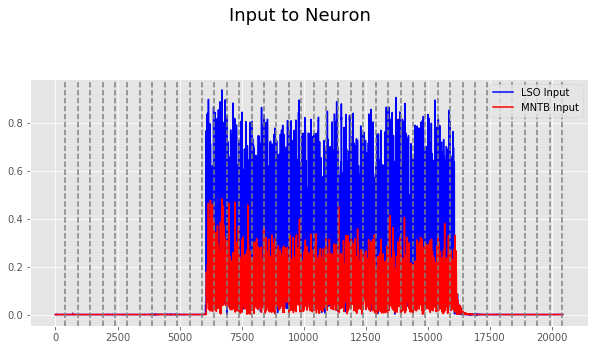

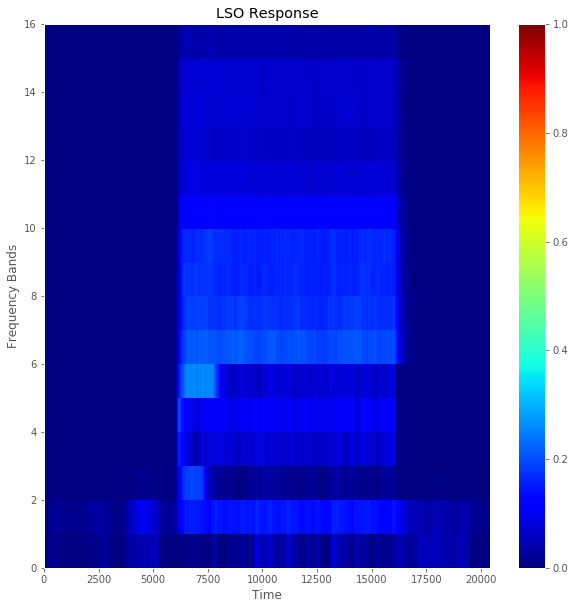

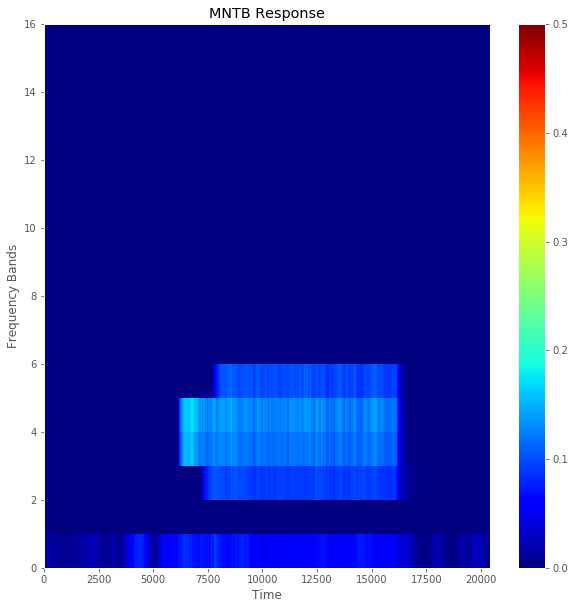

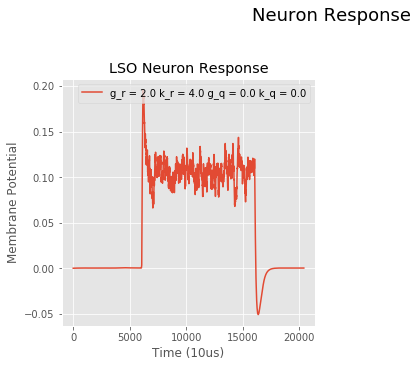

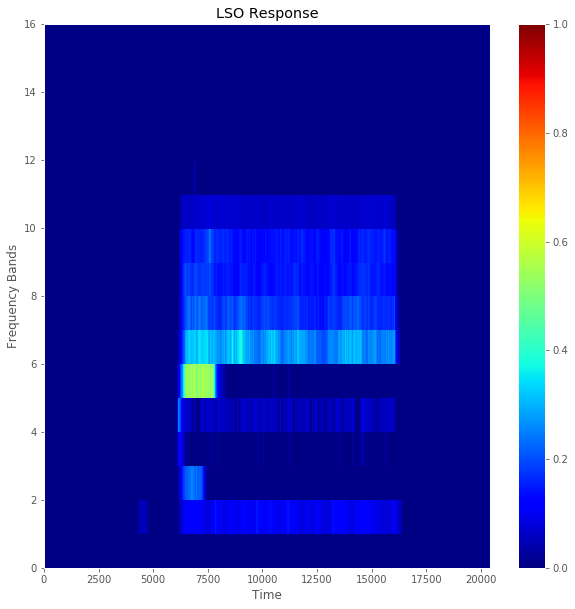

In [63]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(400,len(t),500)

fig = plt.figure(figsize=(10,10))
plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,4],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,4],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.legend()



# ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
# plt.plot(q_all[i,:,3],'red',  label='MNTB Response')
# plt.plot(r_all[i,:,3],'blue', label='LSO Response')
# plt.title('Membrane Potential')
# plt.ylim([0,1])
# plt.legend()

    
fig = plt.figure(figsize=(10,10))
ax = plt.pcolor(r_all[0,:,:].T,cmap='jet',vmin=0., vmax=1.)
plt.title('LSO Response')
plt.xlabel('Time')
plt.ylabel('Frequency Bands')
plt.colorbar()


fig = plt.figure(figsize=(10,10))
ax = plt.pcolor(q_all[0,:,:].T,cmap='jet',vmin=0., vmax=0.5)
plt.title('MNTB Response')
plt.xlabel('Time')
plt.ylabel('Frequency Bands')
plt.colorbar()



fig = plt.figure(figsize=(10,10))
    # show LSO neuron membrane
plt.suptitle('Neuron Response',fontsize=18)

ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(len(gammas_q)):
    stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,4]
    plt.plot(r,label=stri)
plt.title('LSO Neuron Response')
plt.xlabel('Time (10us)')
plt.ylabel('Membrane Potential')
plt.legend()


fig = plt.figure(figsize=(10,10))
ax = plt.pcolor(g_r_out(r_all[0,:,:].T),cmap='jet',vmin=0., vmax=1.)
plt.title('LSO Response')
plt.xlabel('Time')
plt.ylabel('Frequency Bands')
plt.colorbar()


print(np.mean(g_r_out(r_all[0,:,4])))

plt.show()



The reason why the MNTB needs a bigger IE kernel is that its inputs have usually a lower level. That is it either needs to be able to react to smaller changes in the input level or it receives input from a wider range of frequency bands.

In [82]:

# Time step
dt = 0.0001 # -> 10us
# define the inputs
# assuming we have 16 frquency bands
freq_bands = 16

# define the spontaneous firing rate of neuron
spf_r = 0.0


test_ilds = [-90,-70,-50,-30,-10,0,10]
test_ilds = np.arange(-90,-40,10).astype(int)


# define the sample length manually so that we can be sure all recording samples have the same size
s = np.arange(5000,15000)
# store values for different parameters
q_all = np.zeros((len(test_ilds),len(s),freq_bands))
r_all = np.zeros((len(test_ilds),len(s),freq_bands))

for k in range(len(test_ilds)):
    test_ild = test_ilds[k]
    
    print('Reading recording for azimuth : ' + str(test_ild))

    ############################################################
    #                  Input Data Readout                      #
    ############################################################
    stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/whiteNoise_1_20000Hz_normalEars/azimuth_'+str(test_ild)+'/whiteNoise_1_20000Hz_normalEars_azi_'+str(test_ild)+'_ele_0_right.wav'
    data_r = sf.read(stri)[0]
    stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/whiteNoise_1_20000Hz_normalEars/azimuth_'+str(test_ild)+'/whiteNoise_1_20000Hz_normalEars_azi_'+str(test_ild)+'_ele_0_left.wav'
    data_l = sf.read(stri)

    # get the rate
    fs = data_l[1]
    data_l = data_l[0]


    psd_l = pretty_spectrogram(data_l,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps
    psd_r = pretty_spectrogram(data_r,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps


    s_gbc_all= psd_l[s]
    s_sbc_all = psd_r[s]

    T = s_gbc_all.shape[0]/10000

    # Solve differential equation from time 0 to time T
    # Descretize time into equal steps
    t = np . linspace (0 , T , int ( T / dt ))
    

    ############################################################
    #                Network Inputs/Outputs                    #
    ############################################################


    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= 12
    s_sbc_all /= 12


    ############################################################
    #                      Simulation                          #
    ############################################################

    # define the spontaneous firing rate of neuron
    spf_r = 0.0
    r_all[:,0,:] = 0.0


    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,2.0)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 2
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r)       

            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)


    

Reading recording for azimuth : -90
Reading recording for azimuth : -80
Reading recording for azimuth : -70
Reading recording for azimuth : -60
Reading recording for azimuth : -50
Reading recording for azimuth : -40
Reading recording for azimuth : -30
Reading recording for azimuth : -20
Reading recording for azimuth : -10
Reading recording for azimuth : 0


[0.02572389 0.02523974 0.03361935 0.03127868 0.0271985  0.01779919
 0.00808964 0.0067011  0.00669285 0.00669285]


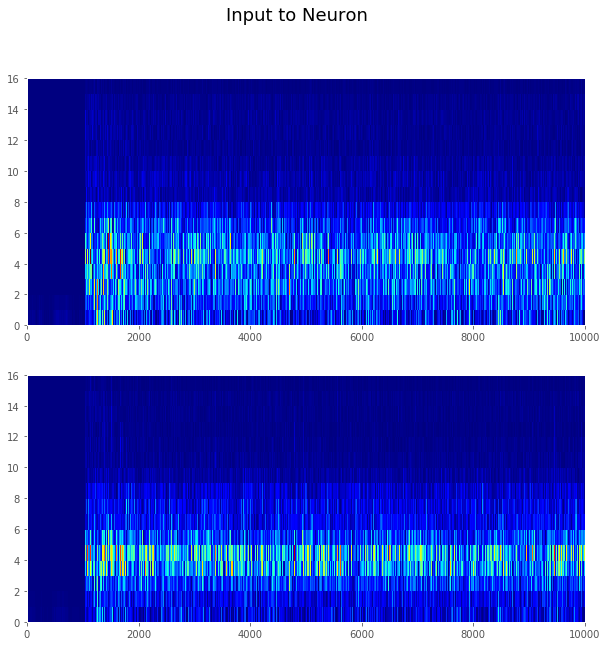

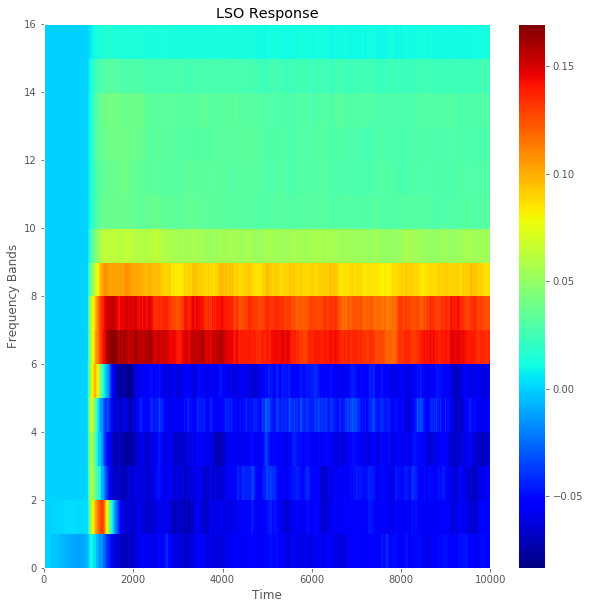

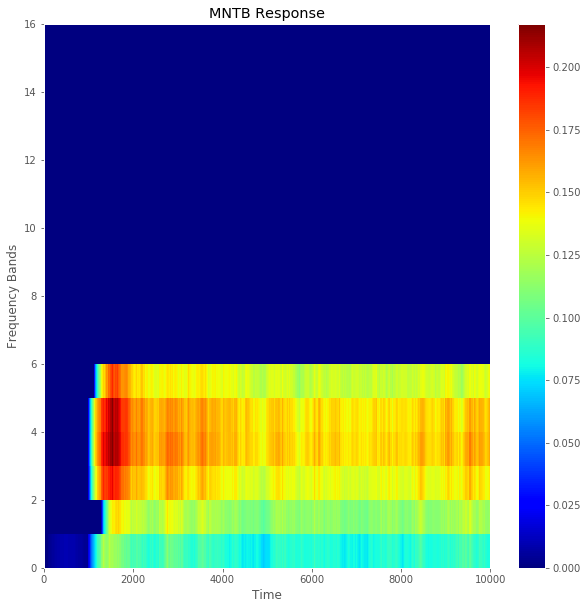

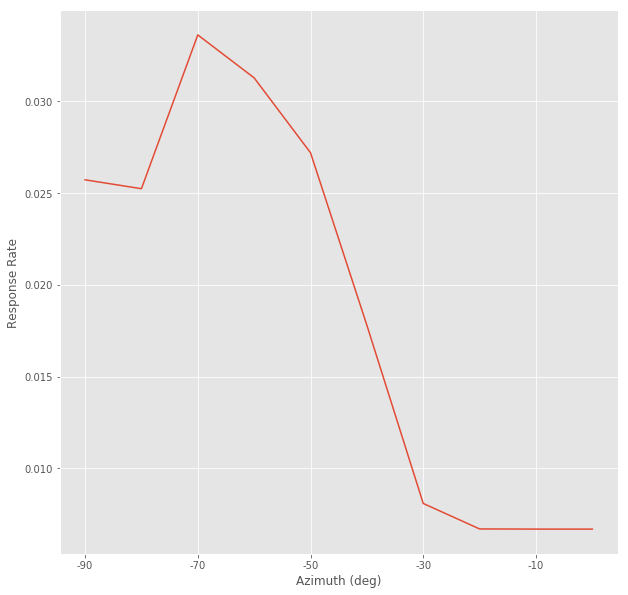

In [86]:

############################################################
#                       Plotting                           #
############################################################

fig = plt.figure(figsize=(10,10))
plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.pcolor(s_sbc_all[:,:].T,cmap='jet')
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.pcolor(s_gbc_all[:,:].T,cmap='jet')
# for i in probing_times:
#     plt.axvline(x=i,linestyle='--',color='grey')
# plt.legend()



# ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
# plt.plot(q_all[i,:,3],'red',  label='MNTB Response')
# plt.plot(r_all[i,:,3],'blue', label='LSO Response')
# plt.title('Membrane Potential')
# plt.ylim([0,1])
# plt.legend()

    
# fig = plt.figure(figsize=(10,10))
# ax = plt.pcolor(r_all[0,:,:].T,cmap='jet',vmin=0., vmax=1.)
# plt.title('LSO Response')
# plt.xlabel('Time')
# plt.ylabel('Frequency Bands')
# plt.colorbar()

fig = plt.figure(figsize=(10,10))
ax = plt.pcolor(r_all[5,:,:].T,cmap='jet')
plt.title('LSO Response')
plt.xlabel('Time')
plt.ylabel('Frequency Bands')
plt.colorbar()

# fig = plt.figure(figsize=(10,10))
# ax = plt.pcolor(r_all[2,:,:].T,cmap='jet',vmin=0., vmax=1.)
# plt.title('LSO Response')
# plt.xlabel('Time')
# plt.ylabel('Frequency Bands')
# plt.colorbar()

fig = plt.figure(figsize=(10,10))
ax = plt.pcolor(q_all[5,:,:].T,cmap='jet')
plt.title('MNTB Response')
plt.xlabel('Time')
plt.ylabel('Frequency Bands')
plt.colorbar()



# fig = plt.figure(figsize=(10,10))
#     # show LSO neuron membrane
# plt.suptitle('Neuron Response',fontsize=18)

# ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
# for i in range(len(gammas_q)):
#     stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
#     diff_input =  s_gbc_all-s_sbc_all
#     diff_input = diff_input[:,3]
#     r = r_all[i,:,4]
#     plt.plot(r,label=stri)
# plt.title('LSO Neuron Response')
# plt.xlabel('Time (10us)')
# plt.ylabel('Membrane Potential')
# plt.legend()


# fig = plt.figure(figsize=(10,10))
# ax = plt.pcolor(g_r_out(r_all[0,:,:].T),cmap='jet',vmin=0., vmax=1.)
# plt.title('LSO Response')
# plt.xlabel('Time')
# plt.ylabel('Frequency Bands')
# plt.colorbar()


# print(np.mean(g_r_out(r_all[0,:,4])))
# print(np.mean(g_r_out(r_all[1,:,4])))
# print(np.mean(g_r_out(r_all[2,:,4])))
# print(np.mean(g_r_out(r_all[3,:,4])))
# print(np.mean(g_r_out(r_all[4,:,4])))
# print(np.mean(g_r_out(r_all[5,:,4])))
fig = plt.figure(figsize=(10,10))

print(np.mean(g_r_out(r_all[:,:,:]),axis=(1,2)))
plt.plot((np.mean(g_r_out(r_all[:,:,:]),axis=(1,2))))
plt.xticks([0,2,4,6,8],[-90,-70,-50,-30,-10])
plt.xlabel('Azimuth (deg)')
plt.ylabel('Response Rate')
plt.show()

